In [5]:
import os
import requests

def save_and_cache(url, path, force=False):
    if not os.path.exists(path) or force:
        print(f"Downloading {url} to {path} ...")
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)

# 疫情数据

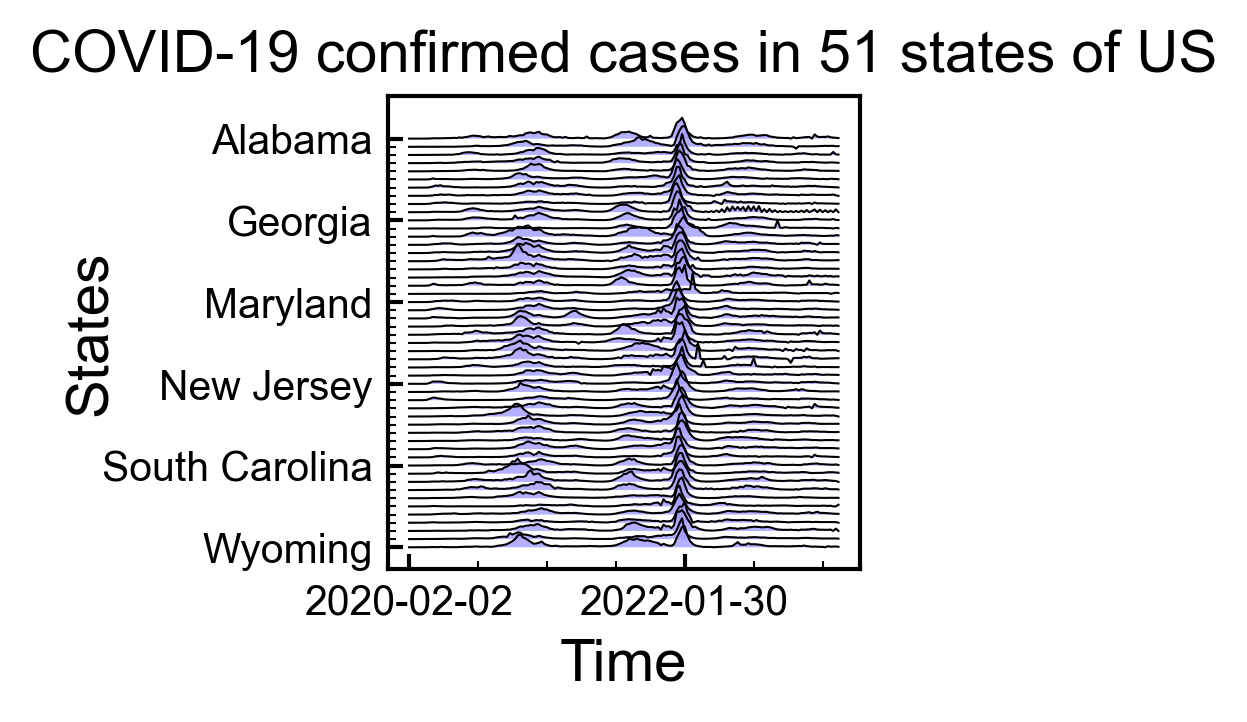

(51,) (163,) (163, 51)


In [6]:
import numpy as np
import pandas as pd

save_and_cache('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv', '../data/epidemic/time_series_covid19_confirmed_US.csv')
df_US = pd.read_csv('../data/epidemic/time_series_covid19_confirmed_US.csv')
df_US.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], inplace=True)
df_US = df_US.groupby('Province_State').sum()
df_US.drop(index=['American Samoa', 'Diamond Princess', 'Grand Princess', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands'], inplace=True) # drop non-states
df_US.sort_index(inplace=True)

# 等间隔为 1 日
assert len(pd.to_datetime(df_US.columns.values, format='%m/%d/%y').diff()[1:].unique()) == 1
# 汇总为 1 周的数据
df_US.columns = pd.to_datetime(df_US.columns, format='%m/%d/%y')
df_US = df_US.T.resample('W').max().T # 这里是累计确诊数，所以取最大值作为本周累计确诊数

node = df_US.index.values # (N,)
time = pd.to_datetime(df_US.columns, format='%m/%d/%y').astype(str).values[1:] # (T,)
case = np.diff(df_US.values.T, axis=0) # (T, N)

import matplotlib.pyplot as plt
from ND2.utils import get_fig, clear_svg
fi, fig, axes = get_fig(1, 1, AW=4, AH=4, lw=1.0, fontsize=14)

N = 51
dN = 10
dT = 52 * 2
delta = -1
for idx, name in enumerate(node[:N]):
    scale = N / 20 / case[:, idx].max()
    axes[0].plot(case[:, idx] * scale + delta*idx, color='black', lw=fi.lw/2)
    axes[0].fill_between(np.arange(len(time)), case[:, idx] * scale + delta*idx, delta*idx, color='#a29bfe', alpha=0.8, edgecolor=None)
axes[0].set_xticks(np.arange(len(time))[::dT])
axes[0].set_xticks(np.arange(len(time))[::dT//4], minor=True)
axes[0].set_xticklabels(time[::dT], rotation=0, fontsize=0.7*fi.fontsize)
axes[0].set_xlabel('Time', fontsize=fi.fontsize)

axes[0].set_yticks(delta*np.arange(len(node))[:N:dN])
axes[0].set_yticks(delta*np.arange(len(node))[:N], minor=True)
axes[0].tick_params(axis='both', which='minor', width=fi.lw/2)
axes[0].set_yticklabels(node[:N:dN], fontsize=0.7*fi.fontsize)
# axes[0].set_yticklabels([], fontsize=fi.fontsize)
axes[0].set_ylabel('States', fontsize=fi.fontsize, labelpad=-4.0)

axes[0].tick_params(axis='both', which='both', direction='in')
axes[0].set_title(f'COVID-19 confirmed cases in {len(node)} states of US', fontsize=fi.fontsize)
fig.savefig('../plot/epidemic/COVID19inUS.png', dpi=300, transparent=True)
fig.savefig('../plot/epidemic/COVID19inUS.svg', transparent=True)
clear_svg('../plot/epidemic/COVID19inUS.svg')
plt.show()

print(node.shape, time.shape, case.shape)

In [7]:
node

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [8]:
len(node)

51

# OD 数据

In [9]:
import pandas as pd
from tqdm import tqdm

if os.path.exists('../data/epidemic/ODinUS.csv'):
    df = pd.read_csv('../data/epidemic/ODinUS.csv')
else:
    df_list = []
    for year in tqdm(range(2019, 2022)):
        for month in tqdm(range(1, 13)):
            try:
                # df = pd.read_parquet(f'processed/city_level_seats_and_price/2020-{month}.parquet.gz')
                df = pd.read_parquet(f'http://rl2.yumeow.site:8000/{year}-{month}.parquet.gz')
                df = df[(df['Dep Country Code'] == 'US') & (df['Arr Country Code'] == 'US')]
                df = df[['Dep State Name', 'Arr State Name', 'Total Est. Pax']]
                df = df.groupby(['Dep State Name', 'Arr State Name']).sum().reset_index()
                df['Time Series'] = f'{year}-{month:02}'
                df_list.append(df)
            except Exception as e:
                print(f'{year}-{month:02} is not available ({e})')
                continue

    df = pd.concat(df_list)
    df.columns = ['source', 'destination', 'flow', 'time']
    mapping = {'District Of Columbia': 'District of Columbia'}
    df['source'] = df['source'].replace(mapping)
    df['destination'] = df['destination'].replace(mapping)
    # 汇总
    df = df.groupby(['source', 'destination'])['flow'].sum().reset_index()
    df.to_csv('../data/epidemic/ODinUS.csv', index=False)
df

,source,destination,flow
0,Alabama,Alabama,26106
1,Alabama,Alaska,31047
2,Alabama,Arizona,231916
3,Alabama,Arkansas,61805
4,Alabama,California,709012
...,...,...,...
2516,Wyoming,Virginia,23866
2517,Wyoming,Washington,68635
2518,Wyoming,West Virginia,1906
2519,Wyoming,Wisconsin,26052


In [10]:
# 排除没有疫情数据的州
df = df[df['source'].isin(node) & df['destination'].isin(node)]
# 排除自己到自己的流量
df = df[df['source'] != df['destination']]
assert all(np.sort(df['source'].unique()) == node)
assert all(np.sort(df['destination'].unique()) == node)
df

,source,destination,flow
1,Alabama,Alaska,31047
2,Alabama,Arizona,231916
3,Alabama,Arkansas,61805
4,Alabama,California,709012
5,Alabama,Colorado,394064
...,...,...,...
2515,Wyoming,Vermont,4029
2516,Wyoming,Virginia,23866
2517,Wyoming,Washington,68635
2518,Wyoming,West Virginia,1906


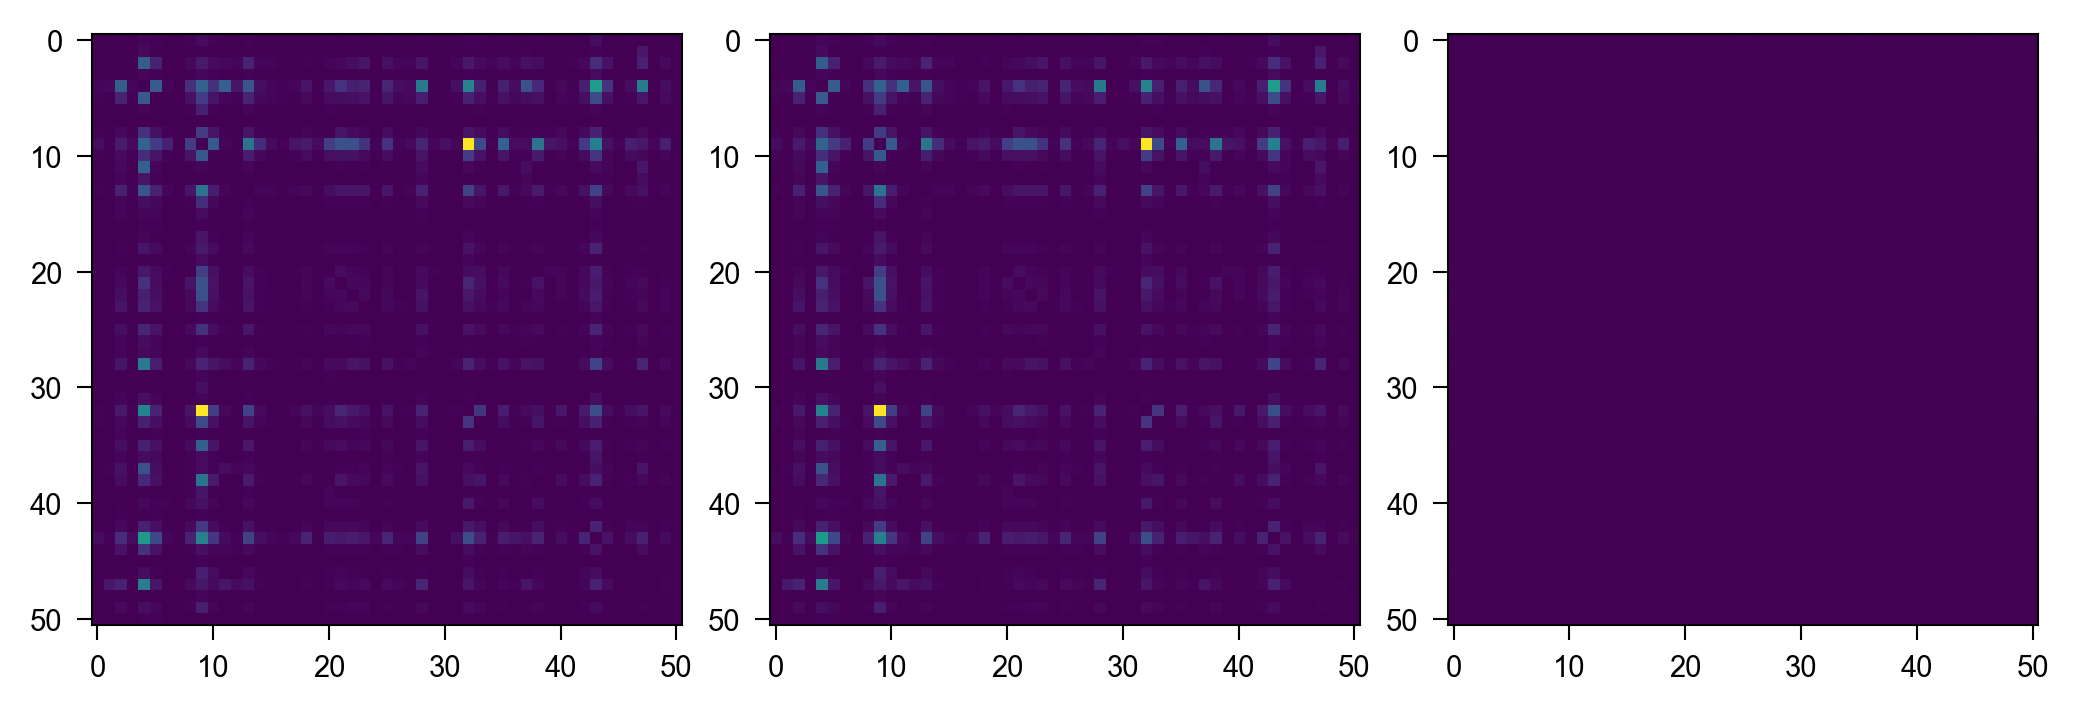

In [12]:
D = 20
df_sparse = df.copy()
df_sparse.sort_values('flow', ascending=False, inplace=True)
df_sparse = df_sparse[:D*len(node)]
df_sparse

from ND2.utils import get_fig
from matplotlib.colors import LogNorm, Normalize
fi, fig, axes = get_fig(1, 3, AW=5)
norm = Normalize(vmin=0, vmax=df['flow'].max())
pivot1 = df.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
pivot2 = df_sparse.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
axes[0].imshow(pivot1.values, norm=norm)
axes[1].imshow(pivot2.values, norm=norm)
axes[2].imshow(pivot1.values - pivot2.values, norm=norm)
plt.show()

In [13]:
df_sparse

,source,destination,flow
1579,New York,Florida,41925826
452,Florida,New York,41796828
244,California,Texas,23209558
2126,Texas,California,22810402
1574,New York,California,18850076
...,...,...,...
100,Arizona,Alabama,243313
21,Alabama,Michigan,243279
19,Alabama,Maryland,242983
823,Kentucky,Arizona,241639


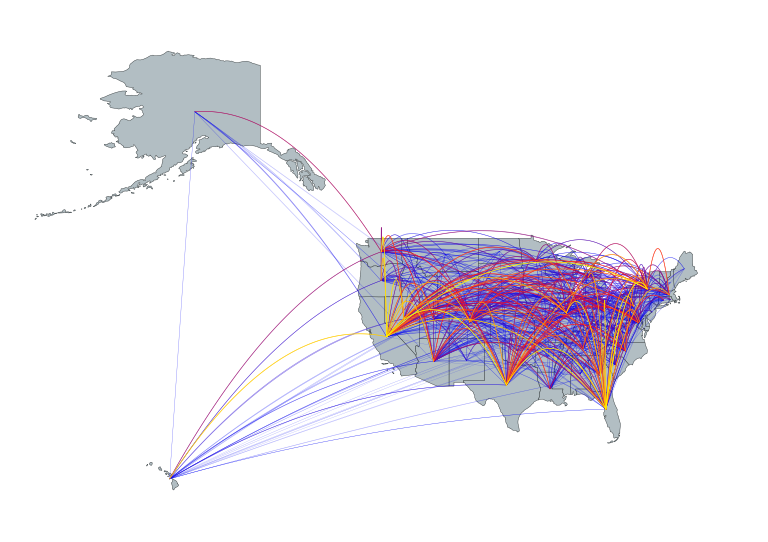

In [15]:
import geopandas as gpd
from ND2.utils.plot import get_fig, plotOD

data = df_sparse
data.columns = ['source', 'destination', 'flow']
# 下载美国州界数据
save_and_cache('https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip', '../data/cb_2022_us_state_20m.zip')
gdf = gpd.read_file('../data/cb_2022_us_state_20m.zip')
gdf = gdf[gdf['NAME'].isin(node)]

fi, fig, axes = get_fig(1, 1, AW=3*2, A_ratio=1, LM=0, RM=0, BM=0, TM=0.0, lw=1.0, fontsize=14)
gdf.plot(ax=axes[0], color='#b2bec3', edgecolor='#2d3436', linewidth=0.1)
axes[0].set_xlim(-180, -60)
location = {row['NAME']: row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
plotOD(axes[0], data['source'], data['destination'], data['flow'], location, linetype='parabola')
axes[0].axis('off')
fig.savefig('../plot/ODinUS.png', dpi=600, transparent=True)
fig.savefig('../plot/ODinUS.svg', transparent=True)

In [16]:
# import numpy as np
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# from matplotlib.colors import LinearSegmentedColormap, Normalize
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# data = df_sparse.copy()

# # 下载美国州界数据
# save_and_cache('https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip',
#                '../data/cb_2022_us_state_20m.zip')
# gdf = gpd.read_file('../data/cb_2022_us_state_20m.zip')
# gdf = gdf[gdf['NAME'].isin(node)]
# gdf = gdf[['NAME', 'geometry']]

# fig = plt.figure(figsize=(12, 8), dpi=600)
# ax = fig.add_subplot(111, projection='3d')

# # 绘制 OD 线路
# center_dict = {row['NAME']:row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
# myhot = LinearSegmentedColormap.from_list('myhot', ['#ffeaa7', '#a29bfe'], gamma=0.6)
# norm = Normalize(vmin=0, vmax=data['flow'].max())
# for idx, row in tqdm(data.iterrows(), total=len(data), desc='Drawing OD Flow'):
#     x1, y1 = center_dict[row['source']]
#     x2, y2 = center_dict[row['destination']]
#     if x1 == x2 and y1 == y2: continue
#     height = row['flow'] + 0.3 * data['flow'].max()  # 根据流量设置高度，可以调整比例
#     t = np.linspace(0, 1, num=100)
#     x = x1 + (x2 - x1) * t
#     y = y1 + (y2 - y1) * t
#     z = height * 4 * t * (1 - t)  # 抛物线方程
#     ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=1.0, zorder=10000+row['flow'], alpha=0.08)
#     ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=0.1, zorder=10000+row['flow'], alpha=1.0)

# ax.set_xlim(*ax.get_xlim()) # fix aspect ratio
# ax.set_ylim(*ax.get_ylim())

# # 绘制区域
# myhsv = LinearSegmentedColormap.from_list('myhsv', ['#d63031', '#e17055', '#fdcb6e', '#00b894', '#00cec9', '#0984e3', '#6c5ce7'])
# norm = Normalize(vmin=0, vmax=len(gdf))
# for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc='Drawing MODZCTA Boundaries'):
#     if row['geometry'].geom_type == 'Polygon':
#         x, y = row['geometry'].exterior.xy
#         poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
#         ax.add_collection3d(poly_collection)
#     elif row['geometry'].geom_type == 'MultiPolygon':
#         for polygon in row['geometry'].geoms:
#             x, y = polygon.exterior.xy
#             poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
#             ax.add_collection3d(poly_collection)

# # 设置视角和标签
# # ax.set_xlabel('Longitude')
# # ax.set_ylabel('Latitude')
# # ax.set_title('OD Flow')
# ax.axis('off')

# # X = np.linspace(*ax.get_xlim(), 10)
# # Y = np.linspace(*ax.get_ylim(), 10)
# # X, Y = np.meshgrid(X, Y)
# # Z = np.zeros_like(X)
# # ax.plot_surface(X, Y, Z, zorder=0, color='#000034', alpha=0.1)

# # ax.set_facecolor('lightblue')
# fig.tight_layout()

# plt.show()

# 保存数据

In [17]:
import json

state2idx = {s:idx for idx, s in enumerate(node)}
df_sparse['source_idx'] = df_sparse['source'].map(state2idx).astype(int)
df_sparse['destination_idx'] = df_sparse['destination'].map(state2idx).astype(int)
G = df_sparse[['source_idx', 'destination_idx']].values
A = np.zeros((len(node), len(node)))
A[G[:, 0], G[:, 1]] = 1

save = {}
save['node'] = node.tolist() # (N,)
save['time'] = time.tolist() # (T,)
save['case'] = case.tolist() # (T, N)
save['flow'] = df_sparse['flow'].values.tolist() # (E,)
save['A'] = A.tolist() # (N, N)
save['G'] = G.tolist() # (E, 2)
with open('../data/COVID19inUS.json', 'w') as f:
    json.dump(save, f)

for key, value in save.items():
    print(f'{key:10} -> {np.array(value).shape}')

node       -> (51,)
time       -> (163,)
case       -> (163, 51)
flow       -> (1020,)
A          -> (51, 51)
G          -> (1020, 2)
